In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/covidandnorm.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_DATASET_2_CLASSES/val/Normal/Normal-2951.png  
  inflating: COVID-19_DATASET_2_CLASSES/train/COVID/COVID-620.png  
  inflating: COVID-19_DATASET_2_CLASSES/val/Normal/Normal-3330.png  
  inflating: COVID-19_DATASET_2_CLASSES/val/Normal/Normal-2952.png  
  inflating: COVID-19_DATASET_2_CLASSES/val/Normal/Normal-2948.png  
  inflating: COVID-19_DATASET_2_CLASSES/train/COVID/COVID-595.png  
  inflating: COVID-19_DATASET_2_CLASSES/val/Normal/Normal-3332.png  
  inflating: COVID-19_DATASET_2_CLASSES/val/Normal/Normal-3342.png  
  inflating: COVID-19_DATASET_2_CLASSES/val/Normal/Normal-2950.png  
  inflating: COVID-19_DATASET_2_CLASSES/train/COVID/COVID-614.png  
  inflating: COVID-19_DATASET_2_CLASSES/val/Normal/Normal-2947.png  
  inflating: COVID-19_DATASET_2_CLASSES/train/COVID/COVID-622.png  
  inflating: COVID-19_DATASET_2_CLASSES/val/Normal/Normal-2953.png  
  inflating: COVID-19_DATASET_2_CLASSES/val/Normal/Norma

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 16 17:08:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [5]:
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report

import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
train_data_dir = '/content/COVID-19_DATASET_2_CLASSES/train'

In [7]:
valid_data_dir = '/content/COVID-19_DATASET_2_CLASSES/val'

In [8]:
test_data_dir = '/content/COVID-19_DATASET_2_CLASSES/test'# Set the number of classes
num_classes = 2  # COVID-19 positive and negative

# Set the input image size for VGG19
input_shape = (224, 224, 3)

# Set the batch size and number of epochs
batch_size = 32
EPOCHS = 100


In [9]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [10]:
valid_test_data_gen = ImageDataGenerator(rescale=1./255)


In [11]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)


29084464/29084464 [==============================] - 1s 0us/step


In [12]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)


In [13]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

In [14]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
train_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5426 images belonging to 2 classes.


In [16]:
valid_generator = valid_test_data_gen.flow_from_directory(
    valid_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1446 images belonging to 2 classes.


In [17]:
test_generator = valid_test_data_gen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 360 images belonging to 2 classes.


In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=EPOCHS,  # Set a large number of epochs, EarlyStopping will stop training if there is no improvement
    validation_data=valid_generator,
    validation_steps=valid_generator.n // batch_size,
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)


Epoch 1/100
169/169 [==============================] - 102s 497ms/step - loss: 1.7883 - accuracy: 0.8385 - val_loss: 1.5377 - val_accuracy: 0.7625
Epoch 2/100
169/169 [==============================] - 76s 452ms/step - loss: 0.3680 - accuracy: 0.9097 - val_loss: 0.6842 - val_accuracy: 0.8090
Epoch 3/100
169/169 [==============================] - 79s 464ms/step - loss: 0.2623 - accuracy: 0.9234 - val_loss: 0.5930 - val_accuracy: 0.8333
Epoch 4/100
169/169 [==============================] - 77s 454ms/step - loss: 0.2354 - accuracy: 0.9245 - val_loss: 0.4442 - val_accuracy: 0.8535
Epoch 5/100
169/169 [==============================] - 83s 494ms/step - loss: 0.1957 - accuracy: 0.9327 - val_loss: 0.3923 - val_accuracy: 0.8500
Epoch 6/100
169/169 [==============================] - 79s 466ms/step - loss: 0.1859 - accuracy: 0.9283 - val_loss: 0.6219 - val_accuracy: 0.7806
Epoch 7/100
169/169 [==============================] - 83s 489ms/step - loss: 0.1491 - accuracy: 0.9412 - val_loss: 0.3338 

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

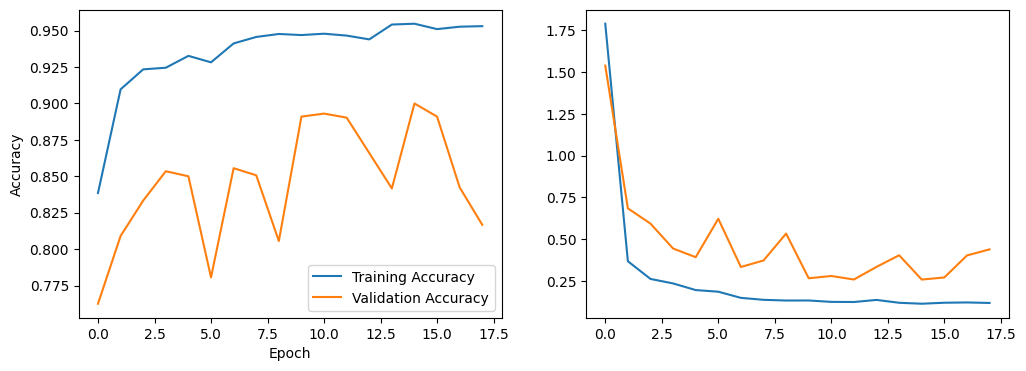

In [19]:
# Plot training accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.n // batch_size)
print('Test accuracy:', test_acc)

<ipython-input-18-11f23487ccdf>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.n // batch_size)


Test accuracy: 0.9460227489471436


In [ ]:
test_generator.reset()
y_pred = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_pred, axis=1)

<ipython-input-19-a59a225fbba3>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator)


In [ ]:
class_labels = list(test_generator.class_indices.keys())
classification_rep = classification_report(y_true, y_pred, target_names=class_labels)
print('Classification Report:')
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

       COVID       0.98      0.91      0.95       180
      Normal       0.92      0.98      0.95       180

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



In [ ]:
model.save('/content/gdrive/MyDrive/606_Covid19_project/Saved_models/Dense_covid')

In [ ]:
def model_predict(img):
    arr_img = tf.keras.utils.img_to_array(img)
    arr_img = np.expand_dims(arr_img, axis = 0)

    # Preprocess the input using VGG-16's preprocess_input() method.
    arr_img_processed = preprocess_input(arr_img)
    
    # Perform prediction.
    result = model.predict(arr_img_processed)


    plt.figure()
    plt.imshow(img)
    print("Prediction Result:")
    print("Class\t\t\t", "Prediction")
    print("COVID\t\t\t", result[0][0] * 100)
    print("Normal\t\t\t", result[0][1] * 100)
    if(result[0][0]<.50):
        result="normal"
    else:
        result="corona positive"
    print("Prediction Result: ", result)

In [ ]:
norm_path = '/content/COVID-19_DATASET_2_CLASSES/test/Normal/Normal-170.png'
cov_path = '/content/COVID-19_DATASET_2_CLASSES/test/COVID/COVID-55.png'

1/1 [==============================] - 0s 141ms/step
Prediction Result:
Class			 Prediction
COVID			 68.63589286804199
Normal			 31.364107131958008
Prediction Result:  corona positive


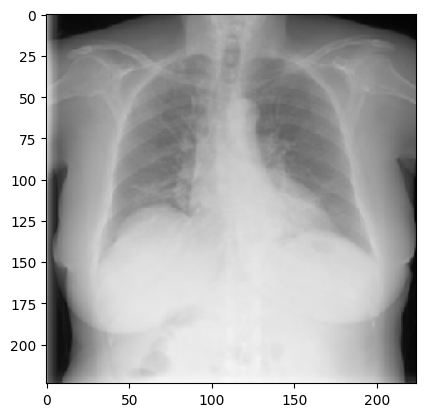

In [ ]:
test_img = tf.keras.utils.load_img(cov_path, target_size = (224, 224))
model_predict(test_img)